# Deep Learning based Suicide and Depression Alert System for Social Media
FYP Submission by: Hoh Shen Yien (TP060158)

The dataset can be found on Kaggle: https://www.kaggle.com/datasets/hohshenyien/fyp-dataset

# Library Imports

In [ ]:
# Installing extra dependencies
!pip install attention
!pip install keras-tuner -q

In [2]:
import numpy as np
import pandas as pd

# Text Preprocessing libraries
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import re

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Vectorization of texts
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec
from gensim.models.callbacks import CallbackAny2Vec

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, Embedding, Activation, TextVectorization, Concatenate, SimpleRNN
from attention import Attention
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TerminateOnNaN
import keras_tuner
from tensorflow.random import set_seed

# Metrics
from sklearn.metrics import classification_report

# Traning helper functions
from sklearn.model_selection import train_test_split

# Utility Functions
import pickle
import shutil
from itertools import chain
from tqdm.auto import tqdm # Showing progress bar
tqdm.pandas()

In [ ]:
data = pd.read_csv("/kaggle/input/depression-suicide/cleaned_data.csv")
data.head()

,content,datetime,label
0,misstoriblack cool i have no tweet applic for...,2009-04-06 23:11:14,neutral
1,tiannachao i know just famili drama it lamehey...,2009-06-23 13:40:11,neutral
2,school email wont open and i have geographi st...,2009-06-01 10:26:07,neutral
3,piginthepok oh whi are you feel like that,2009-06-19 16:11:29,neutral
4,gahh noopeyton need to livethi is horribl,2009-05-11 22:01:32,neutral


# Initial Data Exploration

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2795158 entries, 0 to 2795157
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   content   object
 1   datetime  object
 2   label     object
dtypes: object(3)
memory usage: 64.0+ MB


## Class Counts

In [ ]:
label_info = data['label'].value_counts()
label_info

neutral       1600000
depression     775593
suicide        419564
Name: label, dtype: int64

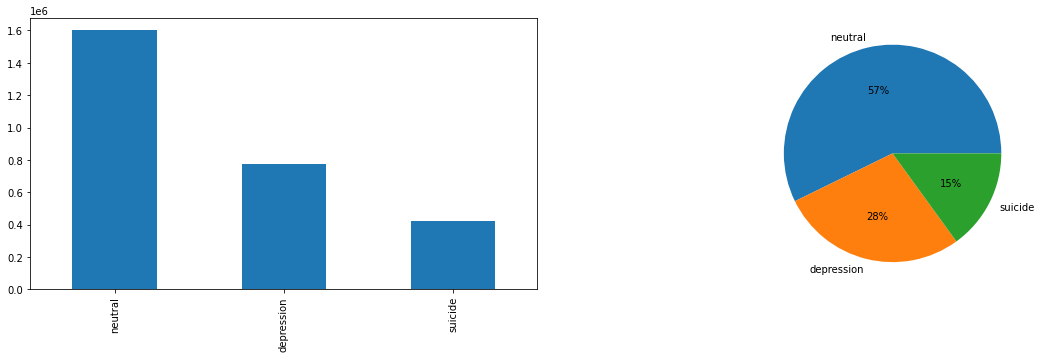

In [ ]:
plt.figure(figsize=((20,5)))

plt.subplot(1,2,1)
label_info.plot.bar()

plt.subplot(1,2,2)
plt.pie(label_info,labels = label_info.index,autopct='%.0f%%')

plt.show()

# Data Preprocessing
## Data Sampling

The data is highly biased, with suicide having the least number of rows, therefore, due to large number of dataset, an undersampling method will be used. 400,000 rows of data will be randomly sampled from each classes.

In [ ]:
n_samples = 400_000

df_balanced = pd.concat([
    data[data['label'] == 'neutral'].sample(n=n_samples, random_state=42),
    data[data['label'] == 'depression'].sample(n=n_samples, random_state=42),
    data[data['label'] == 'suicide'].sample(n=n_samples, random_state=42)
])

df_balanced.shape

(1200000, 3)

In [ ]:
df_balanced['label'].value_counts()

neutral       400000
depression    400000
suicide       400000
Name: label, dtype: int64

In [ ]:
df_balanced.isnull().sum()

content     0
datetime    0
label       0
dtype: int64

## Text Preprocessing

Source: [Tweets Preprocessing](https://www.kaggle.com/code/quentinsarrazin/tweets-preprocessing/notebook)

### Text Cleaning

This involves cleaning symbols, wrong encodings, short forms

In [ ]:
def clean_text(text):
  # Apostrophe
  text = re.sub(r'\x89Ûª', "'", text)
  text = re.sub(r'\x89Û÷', "'", text)

  # Quotation
  text = re.sub(r'\x89ÛÏ', '"', text)
  text = re.sub(r'\x89Û\x9d', '"', text)

  # Hyphen
  text = re.sub(r'\x89ÛÒ', '-', text)
  text = re.sub(r'\x89ÛÓ', '—', text)

  # Euro
  text = re.sub(r'\x89âÂ', '€', text)

  # Ellipsis
  text = re.sub(r'\x89Û_', '...', text)

  # Ampersand
  text = re.sub(r'&', 'and', text)

  # Bullet
  text = re.sub(r"\x89Û¢åÊ", "", text)
  text = re.sub(r'\x89Û¢', '', text)

  # Wrong encodings
  text = re.sub(r"fromåÊwounds", "from wounds", text)
  text = re.sub(r"åÊ", "", text)
  text = re.sub(r"åÈ", "", text)
  text = re.sub(r"JapÌ_n", "Japan", text)
  text = re.sub(r"Ì©", "e", text)
  text = re.sub(r"å¨", "", text)
  text = re.sub(r"SuruÌ¤", "Suruc", text)
  text = re.sub(r"åÇ", "", text)
  text = re.sub(r"å£3million", "3 million ", text)
  text = re.sub(r"åÀ", "", text)

  return text

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

### Creating Corpus

- The texts will be lowercased
- Short forms will be converted to the right word
- Punctuations will be removed
- The stop words will be removed
- The words are stemmed

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "la" : "los angeles",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
def to_lower(text):
    return text.lower()

def remove_punc(text):
    return re.sub(r"[^\w\s]","", text)

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in word_tokenize(text):
        string += word_abbrev(word) + " "        
    return string

def remove_stop_word(text: str):
    stop_words = stopwords.words("english")
    return " ".join(
        [word for word in word_tokenize(text) if word not in (stop_words)]
    )

stemmer = SnowballStemmer("english")
def stem(text):
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

In [ ]:
def preprocess_text(input_data):
    r = clean_text(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = to_lower(r)
    r = remove_punc(r)
    r = replace_abbrev(r)
    r = remove_stop_word(r)
    r = stem(r)
    return r

In [ ]:
df_balanced['content'] = df_balanced['content'].progress_apply(lambda x: preprocess_text(x))

### Cleaning Up
- Also removing texts that are shorter than 40 characters which may not provide much information

In [ ]:
df_filtered = df_balanced[df_balanced["content"].str.len() > 40]
df_filtered.head()

,content,datetime,label
0,misstoriblack cool tweet applic razr 2,2009-04-06 23:11:14,neutral
1,tiannachao know famili drama lamehey next time...,2009-06-23 13:40:11,neutral
2,school email wont open geographi stuff revise ...,2009-06-01 10:26:07,neutral
3,piginthepok oh whi feel like,2009-06-19 16:11:29,neutral
4,gahh noopeyton need livethi horribl,2009-05-11 22:01:32,neutral


In [ ]:
len(df_filtered)

1068399

In [ ]:
df_filtered.label.value_counts()

depression    391043
suicide       386934
neutral       290422
Name: label, dtype: int64

## Output Clean intermediate data
Saving the preprocessed data produced into a csv file, allowing the cleaned data to be reaccessed quickly and easily.

In [ ]:
df_filtered.to_csv("./kaggle/output/cleaned_data.csv", index=False)

In [3]:
df_filtered = pd.read_csv("/kaggle/input/depression-suicide/cleaned_data.csv")
df_filtered.head()

,content,datetime,label
0,misstoriblack cool i have no tweet applic for...,2009-04-06 23:11:14,neutral
1,tiannachao i know just famili drama it lamehey...,2009-06-23 13:40:11,neutral
2,school email wont open and i have geographi st...,2009-06-01 10:26:07,neutral
3,piginthepok oh whi are you feel like that,2009-06-19 16:11:29,neutral
4,gahh noopeyton need to livethi is horribl,2009-05-11 22:01:32,neutral


# Text Visualization
Visualizes the frequency of the words for each category

## Word Frequencies

In [ ]:
def build_word_cloud(label):
    text_suicide = " ".join(content for content in df_filtered[df_filtered["label"] == label].content)
    wordcloud_suicide = WordCloud(background_color="white").generate(text_suicide)
    plt.imshow(wordcloud_suicide, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def describe_texts(label):
    tokens = list(chain(word_tokenize(content) for content in df_filtered[df_filtered["label"] == label].content))
    fdist = FreqDist(tokens)
    print("Top 15 most common tokens:")
    print(fdist.most_common(15))
    print(f"Total tokens: ", len(tokens))
    print(f"Total Unique Tokesn: ", len(fdist))

### Neutral

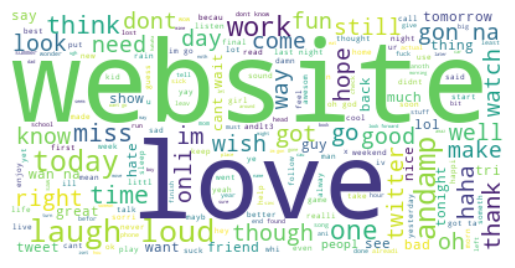

In [ ]:
build_word_cloud("neutral")

In [ ]:
describe_texts("neutral")

Top 15 most common tokens:
[('im', 38863), ('go', 28785), ('get', 25158), ('day', 20143), ('like', 18844), ('good', 18644), ('website', 17595), ('love', 17210), ('work', 16438), ('got', 15443), ('dont', 14920), ('today', 14841), ('time', 13940), ('cant', 13687), ('one', 12839)]
Total tokens:  2774415
Total Unique Tokesn:  250609


### Depression

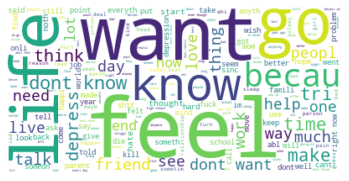

In [ ]:
build_word_cloud("depression")

In [ ]:
describe_texts("depression")

Top 15 most common tokens:
[('im', 896162), ('feel', 668473), ('like', 573433), ('dont', 556872), ('want', 431212), ('get', 429744), ('know', 403803), ('go', 354795), ('life', 324055), ('iv', 323714), ('becaus', 323561), ('time', 316737), ('even', 280069), ('cant', 256266), ('realli', 250809)]
Total tokens:  40528247
Total Unique Tokesn:  245166


### Suicide


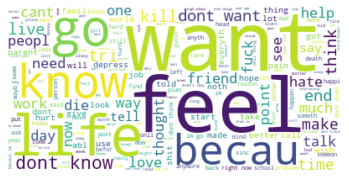

In [ ]:
build_word_cloud("suicide")

In [ ]:
describe_texts("suicide")

Top 15 most common tokens:
[('im', 951266), ('dont', 592888), ('want', 517583), ('feel', 486014), ('like', 462127), ('know', 395298), ('get', 380507), ('life', 369140), ('go', 357594), ('iv', 327156), ('cant', 305300), ('becaus', 301431), ('time', 272628), ('even', 266662), ('think', 249189)]
Total tokens:  38629446
Total Unique Tokesn:  233896


It appears that there are many similar words between depression and suicidal texts, however, there are more extreme words like "die", and "kill" among the suicidal texts. These texts will be one of the determining factors in classifying a text as suicidal.

## Data Preparation

Creating two new columns indicating is_suicide and is_depression

In [4]:
df_filtered['is_dangerous'] = df_filtered['label'].apply(lambda x: 0 if x == "neutral" else 1)
df_filtered['is_suicide'] = df_filtered['label'].apply(lambda x: 1 if x == "suicide" else 0)

df_filtered.head()

,content,datetime,label,is_dangerous,is_suicide
0,misstoriblack cool i have no tweet applic for...,2009-04-06 23:11:14,neutral,0,0
1,tiannachao i know just famili drama it lamehey...,2009-06-23 13:40:11,neutral,0,0
2,school email wont open and i have geographi st...,2009-06-01 10:26:07,neutral,0,0
3,piginthepok oh whi are you feel like that,2009-06-19 16:11:29,neutral,0,0
4,gahh noopeyton need to livethi is horribl,2009-05-11 22:01:32,neutral,0,0


## Train Test Splitting
Splitting the data into train, test and validation with ratio 60%, 20%, 20% respectively.

In [ ]:
def stratify_encode(label):
    if label == "neutral":
        return 0
    if label == "suicide":
        return 1
    return 2

In [5]:
train_data, test_data = train_test_split(df_filtered, test_size=0.4, random_state=42, stratify=df_filtered.label.apply(stratify_encode))
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42, stratify=df_filtered.label.apply(stratify_encode))

# Vectorization
Creating a keras layer that vectorizes the texts into tokens

In [9]:
# Configurations: max_features (vocabs), max length (sequence length)
configurations = [(20_000, 500), (20_000, 200), (10_000, 200), (10_000, 500)]

In [10]:
vectorize_layers = [
    TextVectorization(
    max_tokens=max_feat,
    output_mode='int',
    output_sequence_length=max_len)
    for max_feat, max_len in configurations
]

In [ ]:
[vectorize_layer.adapt(df_filtered['content']) for vectorize_layer in vectorize_layers]

In [ ]:
# Exporting the vectorize_layer for future use
pickle.dump(
    [
        {
            "config": vectorize_layer.get_config(),
            "weights": vectorize_layer.get_weights(),
            "vocabs": vectorize_layer.get_vocabulary(),
            "parameter": configurations[i],
        }
        for i, vectorize_layer in enumerate(vectorize_layers)
    ],
    open("/kaggle/working/vectorizers.pkl", "wb"),
)


In [ ]:
def load_vectorizers():
    global vectorize_layers
    # Importing from disk
    from_disk = pickle.load(open("/kaggle/working/vectorizers.pkl", "rb"))

    vectorize_layers = [
        TextVectorization.from_config(val["config"]) for val in from_disk
    ]

    [
        vectorize_layer.set_weights(from_disk[i]["weights"])
        for i, vectorize_layer in enumerate(vectorize_layers)
    ]


# Modelling

Classify the text as dangerous first, then classify as suicide or depression later

## Helper Functions

These are helper functions to help in training

In [12]:
## This plots the auc against iteration to detect overfitting
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return

In [15]:
lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False, restore_best_weights=True)
tn = TerminateOnNaN()

## Layer 1

This section will try to classify texts as neutral or non-dangerous (suicidal / depressive)

In [ ]:
# Layer 1 - Determining if the texts are neutral or not
X_train = train_data.content
Y_train = train_data.is_dangerous
X_test = test_data.content
Y_test = test_data.is_dangerous

In [ ]:
def create_simple_lstm(config_index):
    max_features, _ = configurations[config_index]
    return Sequential([
        Input(shape=(1,), dtype=tf.string, name='text'),
        vectorize_layers[config_index],
        Embedding(max_features + 1, 128),
        Dropout(0.5),
        LSTM(units=128),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
model_layer_1 = create_simple_lstm(0)

# Compile the model
model_layer_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name="auc")])

model_layer_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,691,841
Trainable params: 2,691,841
Non-trainable params: 0
______________________________________________

In [ ]:
hist = model_layer_1.fit(X_train,
                          Y_train,
                          epochs=10,
                          batch_size=128, 
                          validation_data=(X_test, Y_test), 
                          callbacks=[es,lr])

As layer 1's testing AUC has achieved 0.998, further optimization will be redundant.

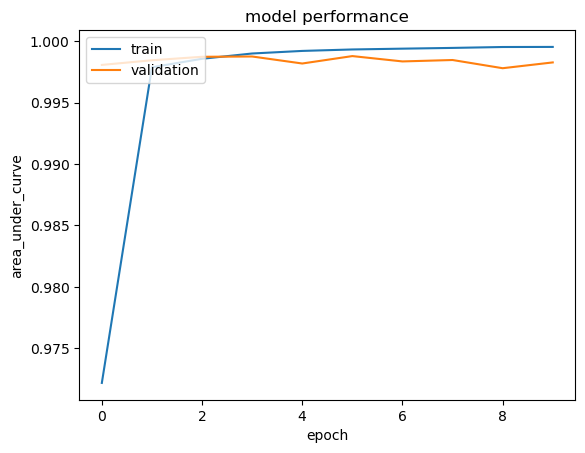

In [ ]:
plot_hist(hist, "auc_1")

In [ ]:
# Exporting the trained model
model_layer_1.save('/kaggle/working/lstm_layer_1.mod')
shutil.make_archive("lstm_layer_1.mod", 'zip', '/kaggle/working/lstm_layer_1.mod')

In [ ]:
model_layer_1 = tf.keras.models.load_model('/kaggle/input/layer-1-model')
model_layer_1.summary()

## Layer 2
This layer will classify suicidal and depressive posts.

In [16]:
# Layer 2 - Distinguishing suicide and depression
X_train_2 = train_data[train_data['is_dangerous'] == 1].content
Y_train_2 = train_data[train_data['is_dangerous'] == 1].is_suicide
X_test_2 = test_data[test_data['is_dangerous'] == 1].content
Y_test_2 = test_data[test_data['is_dangerous'] == 1].is_suicide

### RNN

In [12]:
def create_rnn_tune(units, dropout, lr, embedding_dim, configuration_index):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    model.add(SimpleRNN(units=units))
    if dropout:
        model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc")],
    )
    return model


def tune_rnn(hp):
    units = hp.Int("units", min_value=32, max_value=128, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-3, max_value=1e-1, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=32, max_value=128, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_rnn_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim
    )
    return model

In [13]:
tuner_rnn = keras_tuner.RandomSearch(
    hypermodel=tune_rnn,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=8,
    executions_per_trial=2,
    overwrite=False,
    directory="/kaggle/working",
    project_name="layer_2_rnn",
    
)

tuner_rnn.search(X_train_2, Y_train_2, epochs=4, validation_data=(X_test_2, Y_test_2), callbacks=[es,lr, tn])

tuner_rnn.get_best_models()[0].summary()

Trial 8 Complete [00h 24m 49s]
val_auc: 0.5044804513454437

Best val_auc So Far: 0.5182597637176514
Total elapsed time: 03h 22m 30s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 200, 96)           1920096   
                                                                 
 simple_rnn (SimpleRNN)      (None, 96)                18528     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                        

In [ ]:
tuner_rnn.get_best_hyperparameters()[0].values

{'units': 96,
 'vectorize config': 1,
 'dropout': True,
 'lr': 0.00653844688159917,
 'embedding dim': 96}

In [16]:
shutil.make_archive("layer_2_rnn", 'zip', '/kaggle/working/layer_2_rnn')

'/kaggle/working/layer_2_rnn.zip'

In [14]:
## Training the best model
best_rnn_layer_2 = tuner_rnn.get_best_models()[0]
best_rnn_layer_2.build(X_train_2.shape)
hist = best_rnn_layer_2.fit(X_train_2, 
                            Y_train_2, 
                            epochs=10, 
                            validation_data=(X_test_2, Y_test_2), 
                            callbacks=[es,lr, tn])

Epoch 1/10
14588/14588 [==============================] - 1171s 80ms/step - loss: 0.7120 - auc: 0.5009 - val_loss: 0.6943 - val_auc: 0.5014 - lr: 0.0065
Epoch 2/10
14588/14588 [==============================] - 1095s 75ms/step - loss: 0.7121 - auc: 0.5002 - val_loss: 0.7163 - val_auc: 0.4927 - lr: 0.0065
Epoch 3/10
14588/14588 [==============================] - 1119s 77ms/step - loss: 0.7123 - auc: 0.4999 - val_loss: 0.6968 - val_auc: 0.4994 - lr: 0.0065
Epoch 4/10
14588/14588 [==============================] - 1065s 73ms/step - loss: 0.7121 - auc: 0.5023 - val_loss: 0.7306 - val_auc: 0.4942 - lr: 0.0065
Epoch 5/10
14588/14588 [==============================] - 1079s 74ms/step - loss: 0.7123 - auc: 0.5011 - val_loss: 0.6968 - val_auc: 0.5044 - lr: 0.0065
Epoch 6/10
14588/14588 [==============================] - 1081s 74ms/step - loss: 0.7120 - auc: 0.4999 - val_loss: 0.6996 - val_auc: 0.4968 - lr: 0.0065
Epoch 7/10
14588/14588 [==============================] - 1125s 77ms/step - loss: 

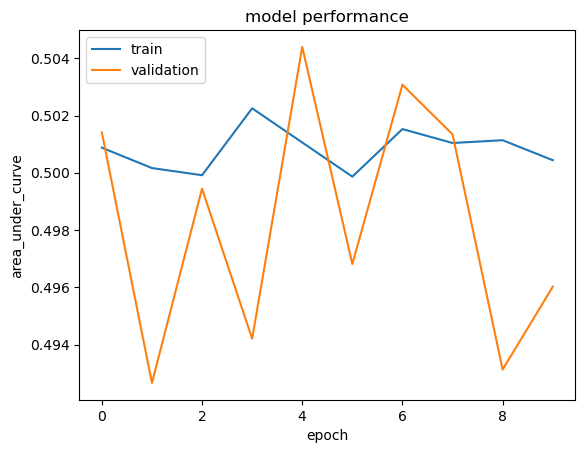

In [15]:
plot_hist(hist)

In [17]:
best_rnn_layer_2.save('/kaggle/working/best_rnn_layer_2.mod')
shutil.make_archive("best_rnn_layer_2.mod", 'zip', '/kaggle/working/best_rnn_layer_2.mod')

'/kaggle/working/best_rnn_layer_2.mod.zip'

### LSTM

In [ ]:
def create_lstm_tune(units, dropout, lr, embedding_dim, configuration_index):
    max_features, _ = configurations[configuration_index]
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string, name='text'))
    model.add(vectorize_layers[configuration_index])
    model.add(Embedding(max_features + 1, embedding_dim))
    if dropout:
        model.add(Dropout(rate=0.5))
    model.add(LSTM(units=units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc")],
    )
    return model


def tune_lstm(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim
    )
    return model

In [ ]:
tuner_lstm = keras_tuner.RandomSearch(
    hypermodel=tune_lstm,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=8,
    executions_per_trial=2,
    overwrite=False,
    directory="/kaggle/working",
    project_name="layer_2_lstm",
)

tuner_lstm.search(X_train_2, Y_train_2, epochs=4, validation_data=(X_test_2, Y_test_2), callbacks=[es,lr, tn])

tuner_lstm.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 64)           640064    
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,153
Trainable params: 673,153
Non-trainable params: 0
__________________________________________________

In [ ]:
tuner_lstm.get_best_hyperparameters()[0].values

{'units': 64,
 'vectorize config': 3,
 'dropout': True,
 'lr': 0.0010820242763584396,
 'embedding dim': 64}

In [ ]:
shutil.make_archive("layer_2_lstm", 'zip', '/kaggle/working/layer_2_lstm')

In [ ]:
## Training the best model
best_lstm_layer_2 = tuner_lstm.get_best_models()[0]
best_lstm_layer_2.build(X_train_2.shape)
hist = best_lstm_layer_2.fit(X_train_2, 
                             Y_train_2, 
                             epochs=10, 
                             validation_data=(X_test_2, Y_test_2), 
                             callbacks=[es,lr, tn])

Epoch 1/10
14588/14588 [==============================] - 713s 49ms/step - loss: 0.4854 - auc: 0.8450 - val_loss: 0.4956 - val_auc: 0.8403 - lr: 0.0011
Epoch 2/10
14588/14588 [==============================] - 600s 41ms/step - loss: 0.4796 - auc: 0.8493 - val_loss: 0.4922 - val_auc: 0.8403 - lr: 0.0011
Epoch 3/10
14588/14588 [==============================] - 601s 41ms/step - loss: 0.4750 - auc: 0.8524 - val_loss: 0.4946 - val_auc: 0.8404 - lr: 0.0011
Epoch 4/10
14588/14588 [==============================] - 572s 39ms/step - loss: 0.4712 - auc: 0.8552 - val_loss: 0.4942 - val_auc: 0.8404 - lr: 0.0011
Epoch 5/10
14588/14588 [==============================] - 572s 39ms/step - loss: 0.4677 - auc: 0.8576 - val_loss: 0.4993 - val_auc: 0.8401 - lr: 0.0011
Epoch 6/10
14588/14588 [==============================] - 568s 39ms/step - loss: 0.4649 - auc: 0.8595 - val_loss: 0.4979 - val_auc: 0.8396 - lr: 0.0011
Epoch 7/10
14588/14588 [==============================] - 570s 39ms/step - loss: 0.4625 

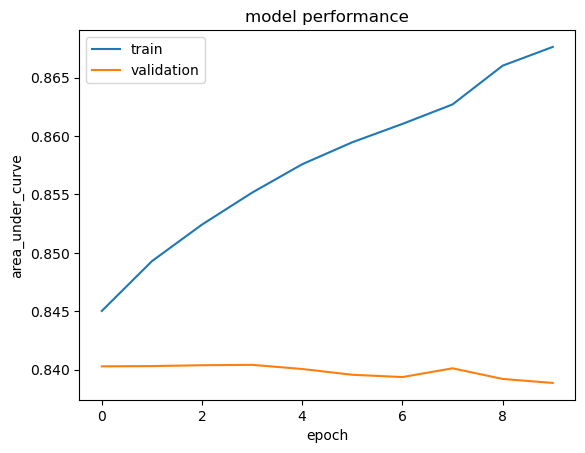

In [ ]:
plot_hist(hist)

In [ ]:
best_lstm_layer_2 = tuner_lstm.get_best_models()[0]

In [ ]:
best_lstm_layer_2.save('/kaggle/working/best_lstm_layer_2.mod')
shutil.make_archive("best_lstm_layer_2.mod", 'zip', '/kaggle/working/best_lstm_layer_2.mod')

In [ ]:
best_lstm_layer_2 = tf.keras.models.load_model('/kaggle/working/best_lstm_layer_2.mod')

### LSTM with Attention

In [ ]:
def create_lstm_attention_tune(units, dropout, lr, embedding_dim, configuration_index, attention_units):
    max_features, _ = configurations[configuration_index]
    text_input = Input(shape=(1,), dtype=tf.string, name='text')
    x = vectorize_layers[configuration_index](text_input)
    x = Embedding(max_features + 1, embedding_dim)(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = LSTM(units=units, return_sequences=True)(x)
    x = Attention(units=attention_units)(x)
    x = Dense(1)(x)
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    model = tf.keras.Model(text_input, predictions)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc")],
    )
    return model


def tune_lstm_attention(hp):
    units = hp.Int("units", min_value=32, max_value=256, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    attention_units = hp.Int("attention units", min_value=16, max_value=64, step=16)
    
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_attention_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim, attention_units=attention_units
    )
    return model

In [ ]:
tuner_lstm_attention = keras_tuner.RandomSearch(
    hypermodel=tune_lstm_attention,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=10,
    executions_per_trial=2,
    overwrite=False,
    directory="/kaggle/working",
    project_name="layer_2_lstm_attention",
)

tuner_lstm_attention.search(X_train_2, Y_train_2, epochs=4, validation_data=(X_test_2, Y_test_2), callbacks=[es,lr, tn])

tuner_lstm_attention.get_best_models()[0].summary()

Trial 10 Complete [00h 46m 14s]
val_auc: 0.8249240219593048

Best val_auc So Far: 0.837759718298912
Total elapsed time: 01h 54m 30s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 192)          3840192   
                                                                 
 lstm (LSTM)                 (None, 500, 32)           28800     
                                                                 
 attention (Attention)       (None, 48)                4096      
                                                             

In [ ]:
tuner_lstm_attention.get_best_hyperparameters()[0].values

{'units': 32,
 'vectorize config': 0,
 'dropout': False,
 'lr': 0.000307201856805808,
 'embedding dim': 192,
 'attention units': 48}

In [ ]:
shutil.make_archive("layer_2_lstm_attention", 'zip', '/kaggle/working/layer_2_lstm_attention')

'/kaggle/working/layer_2_lstm_attention.zip'

In [ ]:
## Training the best model
best_lstm_attention_layer_2 = tuner_lstm_attention.get_best_models()[0]
best_lstm_attention_layer_2.build(X_train_2.shape)
hist_lstm_attention = best_lstm_attention_layer_2.fit(X_train_2, 
                                                      Y_train_2, 
                                                      epochs=10, 
                                                      validation_data=(X_test_2, Y_test_2), 
                                                      callbacks=[es,lr, tn])

Epoch 1/10
14588/14588 [==============================] - 568s 39ms/step - loss: 0.4519 - auc: 0.8679 - val_loss: 0.5038 - val_auc: 0.8356 - lr: 3.0720e-04
Epoch 2/10
14588/14588 [==============================] - 502s 34ms/step - loss: 0.4324 - auc: 0.8801 - val_loss: 0.5158 - val_auc: 0.8296 - lr: 3.0720e-04
Epoch 3/10
14588/14588 [==============================] - 497s 34ms/step - loss: 0.4103 - auc: 0.8929 - val_loss: 0.5298 - val_auc: 0.8245 - lr: 3.0720e-04
Epoch 4/10
14588/14588 [==============================] - 498s 34ms/step - loss: 0.3865 - auc: 0.9057 - val_loss: 0.5521 - val_auc: 0.8167 - lr: 3.0720e-04
Epoch 5/10
14588/14588 [==============================] - 496s 34ms/step - loss: 0.3620 - auc: 0.9178 - val_loss: 0.5908 - val_auc: 0.8101 - lr: 3.0720e-04
Epoch 6/10
14588/14588 [==============================] - 465s 32ms/step - loss: 0.3251 - auc: 0.9342 - val_loss: 0.6633 - val_auc: 0.7925 - lr: 2.1504e-04
Epoch 7/10
14588/14588 [==============================] - 497s 3

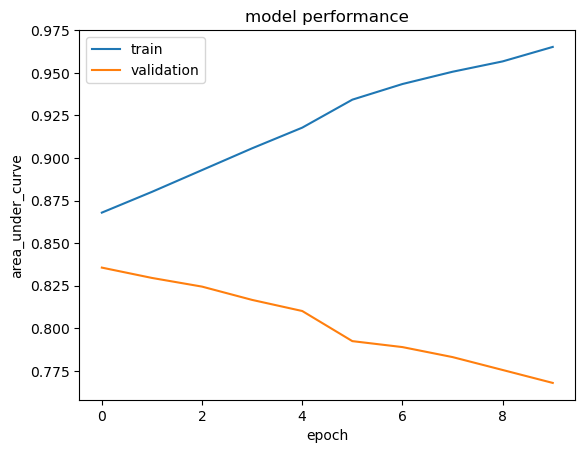

In [ ]:
plot_hist(hist_lstm_attention)

As shown above, the model starts to overfit at the first epoch, therefore, only one additional training is required to train the LSTM with attention.

In [ ]:
best_lstm_attention_layer_2.save("/kaggle/working/overfit_lstm_attention.mod")
shutil.make_archive("overfit_lstm_attention", 'zip', '/kaggle/working/overfit_lstm_attention.mod')

In [ ]:
## Training the best model with only 1 epoch
best_lstm_attention_layer_2 = tuner_lstm_attention.get_best_models()[0]
best_lstm_attention_layer_2.build(X_train_2.shape)
best_lstm_attention_layer_2.fit(X_train_2, 
                                Y_train_2, 
                                epochs=1, 
                                validation_data=(X_test_2, Y_test_2), 
                                callbacks=[es,lr, tn])

14588/14588 [==============================] - 534s 36ms/step - loss: 0.4519 - auc: 0.8679 - val_loss: 0.5051 - val_auc: 0.8355 - lr: 3.0720e-04


In [ ]:
best_lstm_attention_layer_2 = tuner_lstm_attention.get_best_models()[0]
best_lstm_attention_layer_2.build(X_train_2.shape)

In [ ]:
best_lstm_attention_layer_2.save("/kaggle/working/best_lstm_attention_layer_2.mod")
shutil.make_archive("best_lstm_attention_layer_2", 'zip', '/kaggle/working/best_lstm_attention_layer_2.mod')

'/kaggle/working/best_lstm_attention_layer_2.zip'

#### Bi-LSTM

In [17]:
def create_bilstm_tune(units, dropout, lr, embedding_dim, configuration_index, additional_bilstm):
    max_features, _ = configurations[configuration_index]
    text_input = Input(shape=(1,), dtype=tf.string, name='text')
    x = vectorize_layers[configuration_index](text_input)
    x = Embedding(max_features + 1, embedding_dim)(x)
    if dropout:
        x = Dropout(0.5)(x)
    if additional_bilstm:
        x = Bidirectional(LSTM(units=units, return_sequences=True))(x)
    x = Bidirectional(LSTM(units=units // 2))(x)
    x = Dense(1)(x)
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    model = tf.keras.Model(text_input, predictions)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[AUC(name="auc")],
    )
    return model


def tune_bilstm(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    vectorize_layer_ind = hp.Int("vectorize config", min_value=0, max_value=3, step=1)
    dropout = hp.Boolean("dropout")
    additional_bilstm = hp.Boolean("additional_bilstm")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    embedding_dim = hp.Int("embedding dim", min_value=64, max_value=256, step=32)
    
    # call existing model-building code with the hyperparameter values.
    model = create_bilstm_tune(
        units=units, dropout=dropout, lr=lr, configuration_index=vectorize_layer_ind, embedding_dim=embedding_dim, additional_bilstm=additional_bilstm
    )
    return model

In [ ]:
tuner_bilstm = keras_tuner.RandomSearch(
    hypermodel=tune_bilstm,
    objective=keras_tuner.Objective("val_auc", "max"),
    max_trials=10,
    executions_per_trial=2,
    overwrite=False,
    directory="/kaggle/working",
    project_name="layer_2_bilstm",
)

tuner_bilstm.search(X_train_2, Y_train_2, epochs=4, validation_data=(X_test_2, Y_test_2), callbacks=[es,lr, tn])

tuner_bilstm.get_best_models()[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 224)          2240224   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 512)         985088    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                             

In [ ]:
tuner_bilstm.get_best_hyperparameters()[0].values

{'units': 128,
 'vectorize config': 2,
 'dropout': False,
 'additional_bilstm': True,
 'lr': 0.0014544812407025515,
 'embedding dim': 64}

In [19]:
shutil.make_archive("layer_2_bilstm", 'zip', '/kaggle/working/layer_2_bilstm')

'/kaggle/working/layer_2_bilstm.zip'

In [ ]:
best_bilstm_layer_2 = tuner_bilstm.get_best_models()[0]
best_bilstm_layer_2.build(X_train_2.shape)
hist_bilstm = best_bilstm_layer_2.fit(X_train_2, 
                                       Y_train_2, 
                                       epochs=5, 
                                       validation_data=(X_test_2, Y_test_2), 
                                       callbacks=[es,lr, tn])

Epoch 1/5
14588/14588 [==============================] - 1910s 128ms/step - loss: 0.4474 - auc: 0.8708 - val_loss: 0.4922 - val_auc: 0.8428 - lr: 4.1697e-04
Epoch 2/5
14588/14588 [==============================] - 1746s 120ms/step - loss: 0.4287 - auc: 0.8821 - val_loss: 0.5089 - val_auc: 0.8382 - lr: 4.1697e-04
Epoch 3/5
14588/14588 [==============================] - 1741s 119ms/step - loss: 0.4056 - auc: 0.8953 - val_loss: 0.5215 - val_auc: 0.8336 - lr: 4.1697e-04
Epoch 4/5
14588/14588 [==============================] - 1740s 119ms/step - loss: 0.3766 - auc: 0.9104 - val_loss: 0.5577 - val_auc: 0.8227 - lr: 4.1697e-04
Epoch 5/5
14588/14588 [==============================] - 1743s 119ms/step - loss: 0.3457 - auc: 0.9250 - val_loss: 0.5798 - val_auc: 0.8158 - lr: 4.1697e-04


In [ ]:
best_bilstm_layer_2.save("/kaggle/output/layer-2-bilstm-overfit")

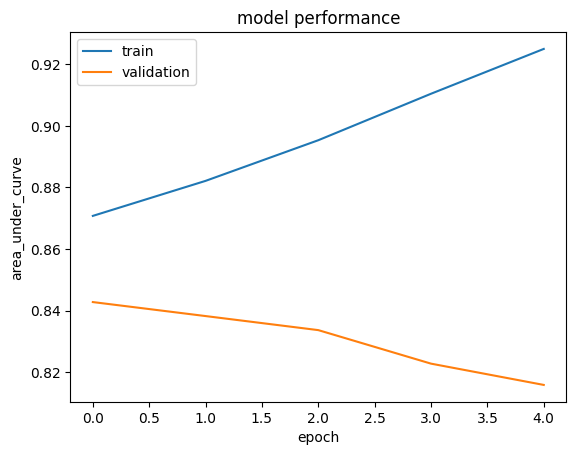

In [ ]:
plot_hist(hist_bilstm)

As shown, it starts to overfit after the 4th epoch, hence, the model at 4th epoch will be used

In [ ]:
best_bilstm_layer_2 = tuner_bilstm.get_best_models()[0]
best_bilstm_layer_2.save("/kaggle/output/best-layer-2-bilstm.mod")

---

# Model Selection

## Metrics

F1 scores will be the primary metrics for selecting the model.
Validation data is used for metrics calculation to ensure that the data is not overfitted.

In [7]:
def classify(row):
    if not row.is_dangerous > 0.5:
        return "neutral"
    if row.is_suicide > 0.5:
        return "suicide"
    return "depression"


def predict(texts, model_layer_1, model_layer_2):
    pred1 = model_layer_1.predict(texts).squeeze() > 0.5
    pred2 = model_layer_2.predict(texts).squeeze() > 0.5
    res = pd.DataFrame(
        list(zip(texts, pred1, pred2)),
        columns=["content", "is_dangerous", "is_suicide"],
    )
    res["prediction"] = res.apply(lambda x: classify(x), axis=1)
    return res


def print_metrics(model_layer_1, model_layer_2):
    predictions = predict(validation_data["content"], model_layer_1, model_layer_2)
    print(classification_report(validation_data.label, predictions.prediction))


### Classifcation Report

In [8]:
## For basic RNN
print("Layer 1: LSTM, Layer 2: RNN")
best_rnn_layer_2 = tf.keras.models.load_model('/kaggle/working/best_rnn_layer_2.mod')
print_metrics(model_layer_1, best_rnn_layer_2)

Layer 1: LSTM, Layer 2: RNN
6678/6678 [==============================] - 134s 20ms/step
              precision    recall  f1-score   support

  depression       0.49      0.85      0.63     77974
     neutral       0.97      0.98      0.98     58084
     suicide       0.49      0.13      0.20     77622

    accuracy                           0.63    213680
   macro avg       0.65      0.65      0.60    213680
weighted avg       0.62      0.63      0.57    213680



In [9]:
## For LSTM
print("Layer 1: LSTM, Layer 2: LSTM")
best_lstm_layer_2 = tf.keras.models.load_model('/kaggle/working/best_lstm_layer_2.mod')
print_metrics(model_layer_1, best_lstm_layer_2)

Layer 1: LSTM, Layer 2: LSTM
6678/6678 [==============================] - 71s 11ms/step
              precision    recall  f1-score   support

  depression       0.78      0.72      0.75     77974
     neutral       0.97      0.98      0.98     58084
     suicide       0.74      0.80      0.77     77622

    accuracy                           0.82    213680
   macro avg       0.83      0.83      0.83    213680
weighted avg       0.82      0.82      0.82    213680



In [12]:
## For LSTM with attentions
print("Layer 1: LSTM, Layer 2: LSTM with attention")
best_lstm_attention_layer_2 = tf.keras.models.load_model('/kaggle/working/best_lstm_attention_layer_2.mod', custom_objects={'Attention': Attention})
print_metrics(model_layer_1, best_lstm_attention_layer_2)

Layer 1: LSTM, Layer 2: LSTM with attention
6678/6678 [==============================] - 75s 11ms/step
              precision    recall  f1-score   support

  depression       0.77      0.74      0.75     77974
     neutral       0.97      0.98      0.98     58084
     suicide       0.75      0.77      0.76     77622

    accuracy                           0.82    213680
   macro avg       0.83      0.83      0.83    213680
weighted avg       0.82      0.82      0.82    213680



In [17]:
## For Bi-LSTM
print("Layer 1: LSTM, Layer 2: Bi-LSTM")
best_bilstm_layer_2 = tf.keras.models.load_model('/kaggle/working/best_bilstm_layer_2.mod')
print_metrics(model_layer_1, best_bilstm_layer_2)

Layer 1: LSTM, Layer 2: Bi-LSTM
6678/6678 [==============================] - 428s 64ms/step
              precision    recall  f1-score   support

  depression       0.77      0.75      0.76     77974
     neutral       0.97      0.98      0.98     58084
     suicide       0.76      0.78      0.77     77622

    accuracy                           0.82    213680
   macro avg       0.83      0.84      0.84    213680
weighted avg       0.82      0.82      0.82    213680



It appears an accuracy of 84% is the best that a deep learning model can achieve in classifying the categories of the texts. This may be due to the limitation of the dataset.